In [218]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as fn
import torch.optim as optim
import torch
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import torch.utils.data as data
from torch.nn.utils.rnn import pack_padded_sequence
import operator
%matplotlib inline

In [2]:
class_to_name = {0: "Heart", 1: "Baseball", 2: "Smile", 3: "Disappointed",
                4: "Fork and Knife"}

In [3]:
def read_data(path):
    sentences = []
    labels = []
    with open(path, "r") as f:
        for line in f:
            columns = line.split(",")
            sentences.append(columns[0].replace('"',"").lower().strip())
            labels.append(int(columns[1]))
    return sentences, labels

def read_glove_vecs(path):
    word_to_vec_map = {}
    word_to_index = {}
    index_to_word = {}
    with open(path, "r") as f:
        for i, line in enumerate(f):
            columns = line.split(" ")
            word = columns[0]
            vector = columns[1:]
            word_to_vec_map[word] = [float(v.strip()) for v in vector]
            word_to_index[word] = i
            index_to_word[i] = word
    return word_to_index, index_to_word, word_to_vec_map

def sentence_to_avg(sentence, word_to_vec_map):
    avg = np.zeros((50,))
    words = [i.lower() for i in sentence.split()]
    for word in words:
        avg += word_to_vec_map[word]
    avg = avg / len(words)
    return avg

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.linear = nn.Linear(50, 25)
        self.linear2 = nn.Linear(25, 5)
        
    def forward(self, avg):
        return fn.softmax(self.linear2(self.linear(avg)), dim=0)
    
def predict(sentence, classifier):
    avg = sentence_to_avg(sentence, word_to_vec_map)
    avg = torch.FloatTensor(avg).to(device)
    predictions = classifier(avg)
    prediction = predictions.argmax().item()
    return class_to_name[prediction], prediction

def evaluate(sentences, labels, classifier):
    correct = 0
    for i in range(len(sentences)):
        sentence = sentences[i]
        label = labels[i]
        class_name, class_index = predict(sentence, classifier)
        correct += class_index == label
    return correct / len(sentences)

## Avg Embeddings Model

In [4]:
n_epochs = 400

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_sentences, train_labels = read_data("/home/tyler/data/text/emoji/train_emoji.csv")
test_sentences, test_labels = read_data("/home/tyler/data/text/emoji/tesss.csv")

In [6]:
max_len = len(max(train_sentences, key=len).split())

In [7]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/home/tyler/data/text/glove/glove.6B.50d.txt')

In [ ]:
classifier = Classifier().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(classifier.parameters(), lr=.001)

In [ ]:
losses = []
for epoch in range(n_epochs):
    sentences, labels = shuffle(train_sentences, train_labels)
    loss_avg = 0
    for i in range(len(sentences)):
        
        classifier.zero_grad()
        
        sentence = sentences[i]
        label = torch.LongTensor([labels[i]]).to(device)
        
        avg = sentence_to_avg(sentence, word_to_vec_map)
        avg = torch.FloatTensor(avg).to(device)
        predictions = classifier(avg)
        loss = criterion(predictions.unsqueeze(0), label)
        loss.backward()
        optimizer.step()
        loss_avg += loss.item()
    losses.append(loss_avg / len(sentences))

In [ ]:
plt.plot(losses)

In [ ]:
predict("lets play ball", classifier)

In [ ]:
evaluate(test_sentences, test_labels, classifier)

In [ ]:
evaluate(train_sentences, train_labels, classifier)

## LSTM

In [8]:
## convert embedding dict to numpy matrix
glove_numpy = np.zeros((len(word_to_vec_map)+1, 50))
for i in range(len(index_to_word)):
    glove_numpy[i,:] = word_to_vec_map[index_to_word[i]]

In [203]:
class EmojiDataset(data.Dataset):
    def __init__(self, sentences, labels, word_to_index, max_len):
        self.sentences = sentences
        self.labels = labels
        self.word_to_index = word_to_index
        self.len = len(labels)
        self.max_len = max_len
        
    def sentence_to_indexes(self, sentence):
        indexes = np.full(max_len, 400000)
        for i, word in enumerate(sentence.split()):
            indexes[i] = word_to_index[word]
        return indexes
        
    def __getitem__(self, index):
        sentence = self.sentences[index]
        label = self.labels[index]
        sentence_tensor = torch.LongTensor(self.sentence_to_indexes(sentence))
        return sentence_tensor, torch.LongTensor([label]), torch.LongTensor([len(sentence.split())])
        
    def __len__(self):
        return self.len

emoji = EmojiDataset(train_sentences, train_labels, word_to_index, max_len)
data_loader = data.DataLoader(dataset=emoji,
                             batch_size=8,
                             shuffle=True)

In [367]:
class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(400001, 50, padding_idx=400000)
        self.embedding.weight.data.copy_(torch.from_numpy(glove_numpy))
        # Don't train the embedding layer since don't have much data
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(50, 128, 2, dropout=0.50,
                            batch_first=True)
        self.linear = nn.Linear(128, 5)
        
    def forward(self, sentence_indexes, lengths):
        embeds = self.embedding(sentence_indexes)
        # the packed sequence allows us to use -1 to get the last non-padded word
        packed = pack_padded_sequence(embeds, list(lengths.data), batch_first=True)
        rnn, _ = self.lstm(embeds)
        # only take last value from LSTM
        out = self.linear(rnn[:,-1,:])
        return out

In [368]:
n_epochs = 30
lstm = LSTMClassifier()
lstm.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, lstm.parameters()), 
                       lr=0.001)
losses = []
for epoch in range(n_epochs):
    loss_avg = 0
    for i, (sentence_indexes, label, length) in enumerate(data_loader):
        
        si2 = np.zeros((sentence_indexes.shape[0], sentence_indexes.shape[1]))
        
        # need to sort them for padding
        sentence_indexes, length, label = zip(*sorted(zip(
            sentence_indexes.numpy(), 
            length.numpy(), label.numpy()), 
            key=operator.itemgetter(1), reverse=True))
        
        length = torch.LongTensor(np.array([x[0] for x in length])).unsqueeze(-1)
        label = torch.LongTensor(np.array([x[0] for x in label])).unsqueeze(-1)
        
        for i, s in enumerate(sentence_indexes):
            si2[i,:] = s
        
        sentence_indexes = torch.LongTensor(si2)
        
        sentence_indexes = sentence_indexes.to(device)
        label = label.to(device)
        length = length.to(device)
        lstm.zero_grad()
        predictions = lstm(sentence_indexes, length)
        loss = criterion(predictions, label.squeeze(-1))
        loss.backward()
        optimizer.step()
        loss_avg += loss.item()
    if epoch % 25 == 0:
        print(epoch)
    losses.append(loss_avg / len(data_loader))

0
25


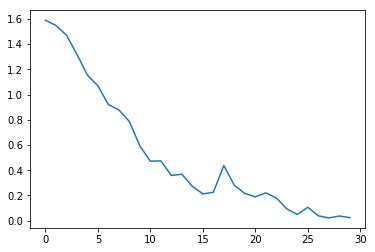

In [369]:
plt.plot(losses)

In [370]:
def predict(sentence, classifier):
        classifier.eval()
        indexes = np.full(max_len, 400000)
        for i, word in enumerate([l.lower() for l in sentence.split()]):
            indexes[i] = word_to_index[word]
        indexes = torch.LongTensor(indexes).to(device)
        indexes = indexes.unsqueeze(0)
        predictions = classifier(indexes, torch.LongTensor([len(sentence.split())]))
        prediction = predictions.argmax().item()
        return class_to_name[prediction], prediction
    
def evaluate(sentences, labels, classifier):
    correct = 0
    for i in range(len(sentences)):
        sentence = sentences[i]
        label = labels[i]
        class_name, class_index = predict(sentence, classifier)
        correct += class_index == label
    return correct / len(sentences)

In [388]:
predict("im not happy to see you", lstm)

('Disappointed', 3)